# Demo - JulES as solar and battery simulator

### Import packages

In [1]:
using Pkg; Pkg.status()
Pkg.add("CSV"); Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables") # package not in JulES environment
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables
# plotlyjs(); # uncomment for interactive plots

In [3]:
config = YAML.load_file(joinpath("data", "config_jules_solbatteri.yml"))
scenarioyear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1];

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 1


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere using JulES
# @everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

In [7]:
function getdataset(config, scenarioyear)
    elements = DataElement[]

    # Solar, battery and transmission parameters
    transmcap = config["data"]["transmcap"] # MW
    transmeff = config["data"]["transmeff"] # Small loss to avoid unnecessary transfers
    storagecap = config["data"]["storagecap"] # GWh
    chargecap = config["data"]["chargecap"]# MW
    lossbattery = config["data"]["lossbattery"] # the whole loss when the battery charges
    solarcap = config["data"]["solarcap"] # MW

    # Power balances for price areas and transmission
    addexogenbalance!(elements, "PowerBalance_ExternalHub", "Power", "AreaPrice")
    price_path = joinpath(config["main"]["inputpath"], config["data"]["price"])
    df = CSV.read(price_path, DataFrame; header=3, decimal=',', types=Float64)
    df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
    df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
    df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => df[:,"Vestsyd"].*1000))) # *1000 to go from €/MWh to €/GWh
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")

    addbalance!(elements, "PowerBalance_HomeHub", "Power")

    addpowertrans!(elements, "PowerBalance_ExternalHub", "PowerBalance_HomeHub", transmcap, transmeff)
    addpowertrans!(elements, "PowerBalance_HomeHub", "PowerBalance_ExternalHub", transmcap, transmeff)

    # Add battery
    addbattery!(elements, "Battery", "PowerBalance_HomeHub", storagecap, lossbattery, chargecap)

    # Add solar production as an RHSTerm
    solar_path = joinpath(config["main"]["inputpath"], config["data"]["solar"]) # profiles from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
    df = CSV.read(solar_path, DataFrame)
    dfmt = DateFormat("yyyy-mm-dd HH:MM:SS")
    df.Timestamp = DateTime.(df.Timestamp, dfmt)
    @assert issorted(df.Timestamp)
    start = first(df.Timestamp)
    numperiods = length(df.Timestamp)
    push!(elements, DataElement(TIMEINDEX_CONCEPT, "RangeTimeIndex", "SolProfileTimeIndex", 
            Dict("Start" => start, "Delta" => Hour(1), "Steps" => numperiods)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT, "VectorTimeValues", "SolProfilValues",
            Dict("Vector" => df.SolarGER)))
    push!(elements, DataElement(TIMEVECTOR_CONCEPT, "RotatingTimeVector", "SolProfil",
            Dict(TIMEVALUES_CONCEPT => "SolProfilValues", TIMEINDEX_CONCEPT => "SolProfileTimeIndex")))
    push!(elements, DataElement(PARAM_CONCEPT, "MWToGWhSeriesParam", "SolParam", Dict("Level" => solarcap, "Profile" => "SolProfil")))
    addrhsterm!(elements, "SolParam", "PowerBalance_HomeHub", DIRECTIONIN)

    return Dict("elements" => elements, "detailedrescopl" => Dict())
end


getdataset (generic function with 1 method)

In [8]:
dataset = getdataset(config, scenarioyear)

Dict{String, Any} with 2 entries:
  "elements"        => DataElement[DataElement("Balance", "ExogenBalance", "Pow…
  "detailedrescopl" => Dict{Any, Any}()

In [9]:
data = JulES.run_serial(config, datayear, scenarioyear, dataset)

Time parameters
  0.030506 seconds (1.28 k allocations: 83.767 KiB, 99.30% compilation time)
Get data
  0.000044 seconds (9 allocations: 656 bytes)
Make dummy objects


  0.469488 seconds (128.32 k allocations: 8.481 MiB, 97.34% compilation time)
Init scenario modelling for simulation, prognosis and stochastic
  0.000047 seconds
Init stochastic


  0.257031 seconds (183.43 k allocations: 12.290 MiB, 97.74% compilation time)


  4.798601 seconds (2.64 M allocations: 174.858 MiB, 2.82% gc time, 96.98% compilation time: <1% of which was recompilation)


  0.081006 seconds (46.33 k allocations: 3.147 MiB, 99.72% compilation time)


  6.945959 seconds (3.65 M allocations: 241.735 MiB, 2.68% gc time, 97.67% compilation time: <1% of which was recompilation)
Init results


  1.390005 seconds (549.85 k allocations: 37.618 MiB, 99.03% compilation time)
Simulate forward


FixedDataTwoTime(

DateTime("2024-12-30T00:00:00"), DateTime("1980-12-31T00:00:00"))


  0.665454 seconds (465.13 k allocations: 26.138 MiB, 95.75% compilation time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-02T00:00:00"))
  0.025794 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-04T00:00:00"))
  0.025243 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-06T00:00:00"))
  0.025141 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-08T00:00:00"))


  0.039741 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-10T00:00:00"))
  0.037323 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-12T00:00:00"))
  0.031239 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-14T00:00:00"))
  0.026822 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-16T00:00:00"))


  0.084159 seconds (117.23 k allocations: 3.149 MiB, 53.09% gc time, 12.92% compilation time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-18T00:00:00"))
  0.027960 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-20T00:00:00"))
  0.034922 seconds (115.46 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-22T00:00:00"))


  0.037907 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-24T00:00:00"))
  0.029521 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-26T00:00:00"))
  0.025580 seconds (115.27 k allocations: 3.016 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-28T00:00:00"))


  0.025041 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-30T00:00:00"))
  0.037351 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-01T00:00:00"))
  0.026337 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-03T00:00:00"))


  0.034308 seconds (115.52 k allocations: 3.029 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-05T00:00:00"))
  0.027905 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-07T00:00:00"))
  0.027092 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-09T00:00:00"))


  0.039802 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-11T00:00:00"))
  0.028690 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-13T00:00:00"))
  0.032707 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-15T00:00:00"))
  0.027947 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-17T00:00:00"))


  0.026802 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-19T00:00:00"))
  0.026593 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-21T00:00:00"))
  0.033753 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-23T00:00:00"))


  0.037044 seconds (115.50 k allocations: 3.026 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-25T00:00:00"))
  0.027966 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-02-27T00:00:00"))


  0.069689 seconds (115.30 k allocations: 3.020 MiB, 58.47% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-01T00:00:00"))
  0.027680 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-03T00:00:00"))
  0.035611 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-05T00:00:00"))


  0.039716 seconds (115.51 k allocations: 3.026 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-07T00:00:00"))
  0.032353 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-09T00:00:00"))
  0.025387 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-11T00:00:00"))


  0.027536 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-13T00:00:00"))
  0.027344 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-15T00:00:00"))
  0.045265 seconds (115.67 k allocations: 3.028 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-17T00:00:00"))


  0.045548 seconds (115.50 k allocations: 3.026 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-19T00:00:00"))
  0.032979 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-21T00:00:00"))
  0.034417 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-23T00:00:00"))


  0.026906 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-25T00:00:00"))
  0.054885 seconds (115.67 k allocations: 3.028 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-27T00:00:00")

)
  0.039072 seconds (115.30 k allocations: 3.019 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-29T00:00:00"))
  0.027013 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-03-31T00:00:00"))
  0.038005 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-02T00:00:00"))


  0.026589 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-04T00:00:00"))
  0.026367 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-06T00:00:00"))
  0.025949 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-08T00:00:00"))
  0.026187 seconds (115.26 k allocations: 3.015 MiB)


FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-10T00:00:00"))
  0.077546 seconds (115.26 k allocations: 3.016 MiB, 45.32% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-12T00:00:00"))


  0.025691 seconds (115.30 k allocations: 3.019 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-14T00:00:00"))
  0.024785 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-16T00:00:00"))
  0.025540 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-18T00:00:00"))


  0.026082 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-20T00:00:00"))
  0.025024 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-22T00:00:00"))
  0.025415 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-24T00:00:00"))
  0.025246 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-26T00:00:00"))


  0.030678 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-28T00:00:00"))
  0.037995 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-04-30T00:00:00"))
  0.026936 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-02T00:00:00"))


  0.025951 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-04T00:00:00"))
  0.037994 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-06T00:00:00"))
  0.026475 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-08T00:00:00"))


  0.025675 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-10T00:00:00"))
  0.025413 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-12T00:00:00"))
  0.025124 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-14T00:00:00"))
  0.025218 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-16T00:00:00"))


  0.026019 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-18T00:00:00"))
  0.048404 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-20T00:00:00"))
  0.028996 seconds (115.27 k allocations: 3.015 MiB)


FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-22T00:00:00"))
  0.054593 seconds (115.27 k allocations: 3.016 MiB, 49.57% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-24T00:00:00"))


  0.045238 seconds (115.72 k allocations: 3.033 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-26T00:00:00"))
  0.027467 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-28T00:00:00"))
  0.025669 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-05-30T00:00:00"))


  0.036025 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-01T00:00:00"))
  0.026632 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-03T00:00:00"))
  0.027293 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-05T00:00:00"))


  0.032382 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-07T00:00:00"))
  0.026792 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-09T00:00:00"))
  0.027118 seconds (115.28 k allocations: 3.018 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-11T00:00:00"))
  0.027783 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-13T00:00:00"))


  0.049119 seconds (115.51 k allocations: 3.026 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-15T00:00:00"))
  0.028629 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-17T00:00:00"))
  0.028369 seconds (115.27 k allocations: 3.016 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-19T00:00:00"))


  0.036873 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-21T00:00:00"))
  0.026781 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-23T00:00:00"))
  0.027989 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-25T00:00:00"))


  0.033735 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-27T00:00:00"))
  0.054585 seconds (115.67 k allocations: 3.028 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-06-29T00:00:00"))
  0.027270 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-01T00:00:00"))


  0.026649 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-03T00:00:00"))
  0.025957 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-05T00:00:00"))
  0.046533 seconds (115.27 k allocations: 3.015 MiB, 43.53% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-07T00:00:00"))


  0.024603 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-09T00:00:00"))
  0.026098 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-11T00:00:00"))
  0.026571 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-13T00:00:00"))


  0.042090 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-15T00:00:00"))
  0.026467 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-17T00:00:00"))
  0.026895 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-19T00:00:00"))
  0.026017 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-21T00:00:00"))


  0.036088 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-23T00:00:00"))
  0.026247 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-25T00:00:00"))
  0.026408 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-27T00:00:00"))


  0.037133 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-29T00:00:00"))
  0.038611 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-07-31T00:00:00"))
  0.026908 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-02T00:00:00"))


  0.026242 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-04T00:00:00"))
  0.024775 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-06T00:00:00"))
  0.026502 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-08T00:00:00"))
  0.039178 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime

("2024-12-30T00:00:00"), DateTime("1981-08-10T00:00:00"))
  0.027272 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-12T00:00:00"))
  0.031879 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-14T00:00:00"))
  0.026885 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-16T00:00:00"))


  0.064752 seconds (115.71 k allocations: 3.032 MiB, 31.30% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-18T00:00:00"))
  0.027261 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-20T00:00:00"))
  0.030648 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-22T00:00:00"))
  0.026882 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-24T00:00:00"))


  0.046500 seconds (115.50 k allocations: 3.026 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-26T00:00:00"))
  0.025924 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-28T00:00:00"))
  0.035243 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-08-30T00:00:00"))
  0.024413 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime

("1981-09-01T00:00:00"))
  0.030577 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-03T00:00:00"))
  0.025360 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-05T00:00:00"))
  0.025003 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-07T00:00:00"))


  0.041160 seconds (115.70 k allocations: 3.032 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-09T00:00:00"))
  0.027207 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-11T00:00:00"))
  0.037145 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-13T00:00:00"))


  0.038555 seconds (115.51 k allocations: 3.026 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-15T00:00:00"))
  0.027816 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-17T00:00:00"))
  0.037722 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-19T00:00:00"))


  0.037061 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-21T00:00:00"))
  0.025413 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-23T00:00:00"))
  0.039916 seconds (115.67 k allocations: 3.028 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-25T00:00:00"))
  0.027042 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-27T00:00:00"))


  0.052597 seconds (115.30 k allocations: 3.020 MiB, 44.78% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-09-29T00:00:00"))
  0.040212 seconds (115.27 k allocations: 3.016 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-01T00:00:00"))
  0.027328 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-03T00:00:00"))


  0.027942 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-05T00:00:00"))
  0.034207 seconds (115.46 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-07T00:00:00"))
  0.026296 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-09T00:00:00"))


  0.037884 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-11T00:00:00"))
  0.038129 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-13T00:00:00"))
  0.036768 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-15T00:00:00"))


  0.026421 seconds (115.31 k allocations: 3.022 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-17T00:00:00"))
  0.032454 seconds (115.46 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-19T00:00:00"))
  0.025735 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-21T00:00:00"))
  0.030148 seconds (115.26 k allocations: 3.015 MiB)


FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-23T00:00:00"))
  0.026112 seconds (115.27 k allocations: 3.016 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-25T00:00:00"))
  0.040452 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime

("2024-12-30T00:00:00"), DateTime("1981-10-27T00:00:00"))
  0.026008 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-29T00:00:00"))
  0.037031 seconds (115.47 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-10-31T00:00:00"))


  0.025750 seconds (115.30 k allocations: 3.019 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-02T00:00:00"))
  0.026342 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-04T00:00:00"))
  0.036337 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-06T00:00:00"))


  0.040886 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-08T00:00:00"))
  0.059463 seconds (115.26 k allocations: 3.015 MiB, 39.20% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-10T00:00:00"))


  0.024367 seconds (115.30 k allocations: 3.019 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-12T00:00:00"))
  0.025219 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-14T00:00:00"))
  0.028134 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-16T00:00:00"))


  0.027610 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-18T00:00:00"))
  0.036177 seconds (115.46 k allocations: 3.021 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-20T00:00:00"))
  0.041274 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-22T00:00:00"))


  0.025766 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-24T00:00:00"))
  0.029285 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-26T00:00:00"))
  0.025600 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-28T00:00:00"))
  0.025275 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-11-30T00:00:00"))


  0.036351 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-02T00:00:00"))
  0.027525 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-04T00:00:00"))
  0.031888 seconds (115.27 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-06T00:00:00"))


  0.025765 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-08T00:00:00"))
  0.036208 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-10T00:00:00"))
  0.025035 seconds (115.26 k allocations: 3.015 MiB)


FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-12T00:00:00"))
  0.026311 seconds (115.27 k allocations: 3.016 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-14T00:00:00"))
  0.024479 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-16T00:00:00"))
  0.025425 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-18T00:00:00"))


  0.038647 seconds (115.30 k allocations: 3.020 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-20T00:00:00"))
  0.047421 seconds (115.27 k allocations: 3.015 MiB, 42.86% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-22T00:00:00"))


  0.041474 seconds (115.30 k allocations: 3.019 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-24T00:00:00"))
  0.038930 seconds (115.26 k allocations: 3.015 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-12-26T00:00:00"))


  0.047746 seconds (115.51 k allocations: 3.026 MiB)
The simulation took: 0.14744291666666667 minutes
Time usage per timestep: 0.04860755494505494 seconds
Handle output

1×11 DataFrame
 Row │ umaster      usub       conv      count    smaster     ssub       hlmas ⋯
     │ Float64      Float64    Float64   Float64  Float64     Float64    Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.000176936  0.0095342  0.020511  2.19337  0.00202353  0.0180387  3.403 ⋯
                                                               5 columns omitted

1×10 DataFrame
 Row │ core   umaster_sum  usub_sum   conv_sum  count_sum  smaster_sum  ssub_s ⋯
     │ Int64  Float64      Float64    Float64   Float64    Float64      Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  0.000176936  0.0095342  0.020511    2.19337   0.00202353  0.0180 ⋯
                                                               4 columns omitted

9-element Vector{Float64}:
 0.00017693591160220995
 0.009534203867403316
 0.02051095635359116
 2.1933701657458564
 0.0020235303867403315
 0.018038717127071825
 3.4033149171270713e-6
 2.3598895027624308e-5
 0.030365577348066296

 10.127998 seconds (9.81 M allocations: 634.177 MiB, 3.23% gc time, 99.48% compilation time: 6% of which was recompilation)


Dict{Any, Any} with 25 entries:
  "svindex"            => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "demandbalancenames" => SubString{String}["HomeHub", "HomeHub", "ExternalHub"…
  "skipfactor"         => 1.0
  "stochastictimes"    => [0.0001857 0.0074395 … 3.78e-5 0.0524083; 0.0001757 0…
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "areanames"          => ["HomeHub", "ExternalHub"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "batmatrix"          => [0.005; 0.005; … ; 0.00118312; 0.00118312;;]
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [0.01 0.005; 0.01 0.005; … ; 0.01 -0.0; 0.01 0.001183…
  "statenames"         => ["BatteryStorage_Battery_max", "BatteryStorage_Batter…
  "resnames"           => String[]
  "shorts"             => Bool[1]
  "demandvalues"       => [0.0 0.0 0.0 -0.0; 0.0 0.0 -0.0 0.0; … ; 0.0 0.0 0.0 …
  "batindex"    

In [10]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = permutedims(data["statematrix"])
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"];

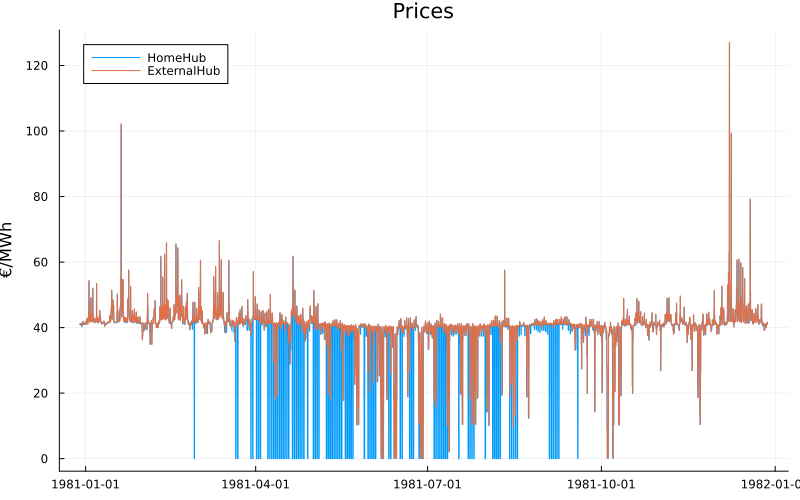

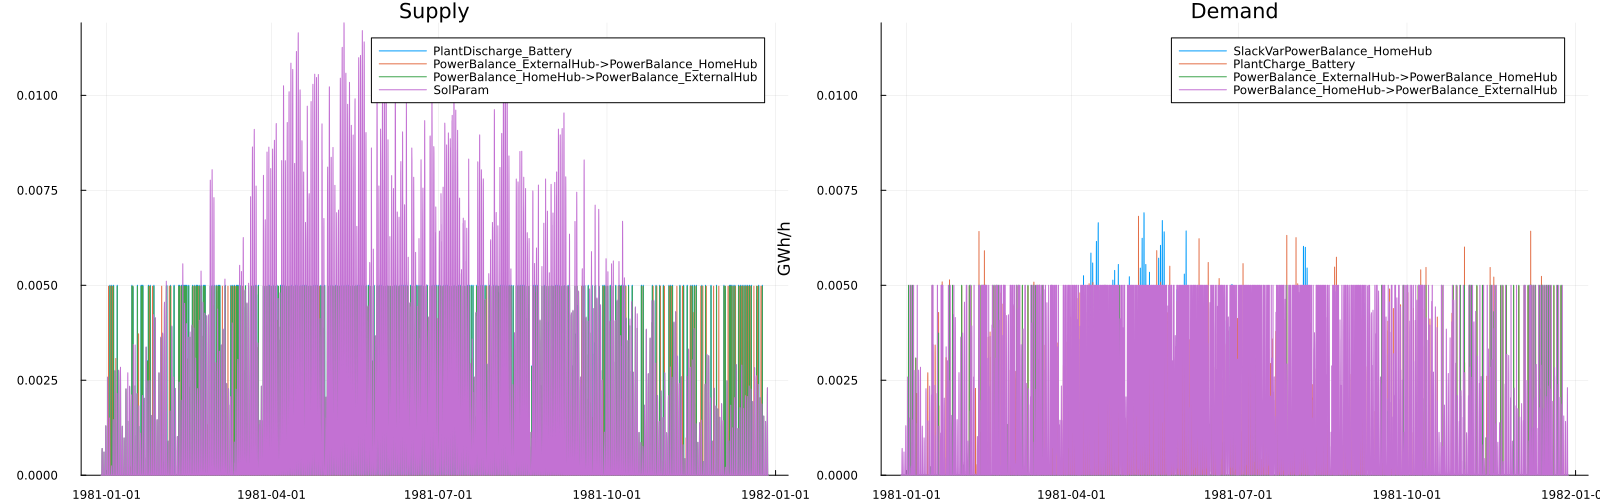

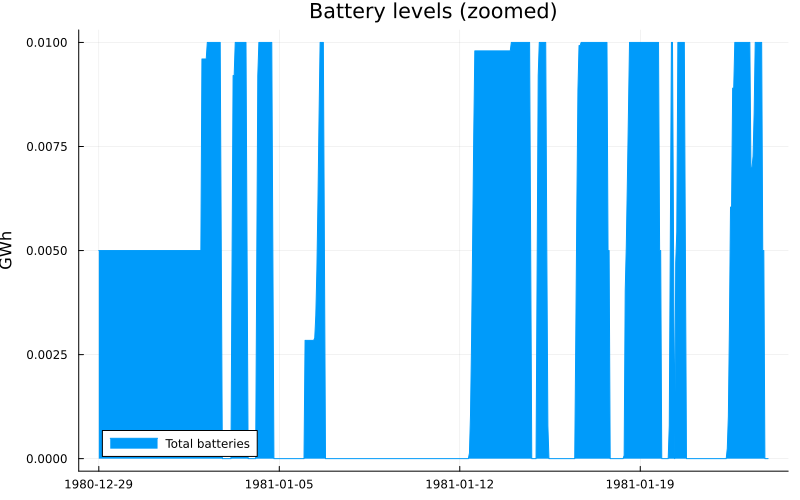

┌────────────────────────────────────────────────┬───────────────────┬────────────────────────────────────────────────┬───────────────────┐
│                                     Supplyname │ Yearly_supply_TWh │                                     Demandname │ Yearly_demand_TWh │
├────────────────────────────────────────────────┼───────────────────┼────────────────────────────────────────────────┼───────────────────┤
│                                       SolParam │          0.013782 │ PowerBalance_HomeHub->PowerBalance_ExternalHub │         0.0133509 │
│ PowerBalance_HomeHub->PowerBalance_ExternalHub │         0.0132841 │                            PlantCharge_Battery │        0.00283175 │
│                         PlantDischarge_Battery │         0.0026232 │                   SlackVarPowerBalance_HomeHub │        0.00102378 │
│ PowerBalance_ExternalHub->PowerBalance_HomeHub │       0.000801159 │ PowerBalance_ExternalHub->PowerBalance_HomeHub │       0.000805185 │
└───────────────────

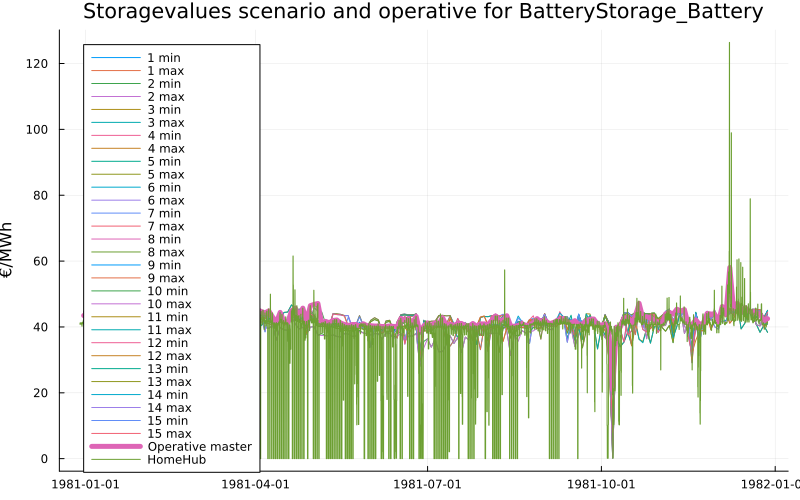

┌────────────────────────────────────────────────┬──────────────────┬────────────────────────────────────────────────┬───────────────────┐
│                                     Supplyname │ Yearly_rev_mill€ │                                     Demandname │ Yearly_cost_mill€ │
├────────────────────────────────────────────────┼──────────────────┼────────────────────────────────────────────────┼───────────────────┤
│ PowerBalance_HomeHub->PowerBalance_ExternalHub │          519.499 │ PowerBalance_HomeHub->PowerBalance_ExternalHub │           390.871 │
│                                       SolParam │          302.884 │                            PlantCharge_Battery │           62.5284 │
│                         PlantDischarge_Battery │          120.038 │ PowerBalance_ExternalHub->PowerBalance_HomeHub │           30.4771 │
│ PowerBalance_ExternalHub->PowerBalance_HomeHub │          30.4771 │                   SlackVarPowerBalance_HomeHub │               0.0 │
└──────────────────────────

In [11]:
# Plot prices
display(plot(x1, prices/1000, labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
display(plot([supplychart,demandchart]...,layout=(1,2),size=(1600,500)))

# Plot storages
display(areaplot(x1[1:624], dropdims(sum(batterylevels,dims=2),dims=2)[1:624],labels="Total batteries",size=(800,500),title="Battery levels (zoomed)", ylabel = "GWh", fmt = :html))

# Plot list of yearly mean production and demand for each supply/demand
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader=false)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader=false)

# Plot list of yearly income and cost for each supply/demand
supplyrev = copy(supplyvalues)
for (i,supplybalancename) in enumerate(supplybalancenames)
    idx = findfirst(isequal(supplybalancename), powerbalancenames)
    supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
end
demandrev = copy(demandvalues)
for (i,demandbalancename) in enumerate(demandbalancenames)
    idx = findfirst(isequal(demandbalancename), powerbalancenames)
    demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
end
meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
supplyrevdf[!,:ID] = collect(1:length(supplynames))
demandrevdf[!,:ID] = collect(1:length(demandnames))
joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
pretty_table(joinedrevdf, show_subheader=false)

# Sum revenues and cost
pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader=false)

# Plot storagevalues for each reservoir and scenarios
numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
numscen = length(scenarionames) - numop
for (i, storagename) in enumerate(storagenames)
    p = plot(x3+Hour(47), storagevalues[:,1:numscen,i] / -1000, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
    plot!(p, x3+Hour(47), storagevalues[:,numscen+1:end,i] / -1000, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
    plot!(p, x1, prices[:, 1] / 1000, labels=powerbalancenames[1])
    display(p)
 end